In [37]:
import json
import random
import csv
import numpy as np

from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn.preprocessing import StandardScaler
from random import randrange
from datetime import datetime, timedelta, time
from dateutil import parser
from statistics import mean

import matplotlib.pyplot as plt
import matplotlib

In [38]:
def date_to_days(date):
    """
    This function returns day of week in range 1-10
    """
    day_t = (float(date.weekday()) *10.0)/6.0
    return day_t


def time_to_seconds(date):
    """
    Function returns time of the day in seconds"""
    td = date.time()
    return ((td.hour * 3600 + td.second) * 10 ** 6 + td.microsecond) / 10 ** 6


def time_to_hours(date):
    """
    Function returns time of the day in hours in range 1-10"""
    td = date.time()
    td_t = (((float(td.hour) * 60 + float(td.minute)) / 60) * 10.0) / 24.0
    return float(td_t)

In [39]:
def read_json(logs_file_path):
    data = []
    # Open Json
    for line in open(logs_file_path, 'r'):
        data.append(json.loads(line))
    return data


# Parse json and extract variables variables


def parse_json(data):
    days = []
    times = []
    ids = []
    intents = []
    params = []
    utt = []
    # parse each json variable
    for i in range(len(data)):
        datetime_object = parser.parse(data[i]["datetime"])
        # Extract day of week
        my_day = date_to_days(datetime_object)
        days.append(my_day)
        # Extract hour of day
        my_hour = time_to_hours(datetime_object)
        times.append(my_hour)
        # Extract intents
        my_id = str(data[i]["type"]) + (str(data[i]["parameters"]))
        m_param = str(data[i]["parameters"])
        ids.append(my_id)
        my_intent = str(data[i]["type"])
        intents.append(my_intent)
        my_param = data[i]["parameters"]
        params.append(my_param)
        my_utterance = str(data[i]["utterance"])
        utt.append(my_utterance)
    X = np.array((days, times, ids, intents, params, utt))
    X = X.transpose()
    print(X.shape)
    return X


def extract_ids(data):
    unique_ids = np.unique(data)
    return unique_ids


raw_data = read_json("/opt/mycroft/habits/logs.json")
X = parse_json(raw_data)
# Take hour and day for clustering
X_cluster = X[:, [0, 1]]
# compute dbscan per id
unique_ids = extract_ids(X[:, [0, 1]])

(310, 6)


In [46]:
# MODELS
# Compute Affinity Propagation
def compute_AP(features):
    af = AffinityPropagation(preference=-50, damping=0.9).fit(features)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    return cluster_centers_indices, labels


def compute_DBSCAN(features):
    features = StandardScaler().fit_transform(features.astype(float))
    # #############################################################################
    # Compute DBSCAN
    db = DBSCAN(eps=0.25, min_samples=4).fit(features)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    return core_samples_mask, labels

In [47]:
# Plot models
# PLot AP according to their cluster
def plot_AP(features, cci,labels_AP,name):
    
    n_clusters_ = len(cci)
    colors = gen_colors(n_clusters_)
    
    for k, my_col in zip(range(n_clusters_), colors):
        class_members = labels_AP == k
        cluster_center = features[cci[k]]
        col = matplotlib.colors.to_hex((my_col))
        plt.plot(features[class_members, 0], features[class_members, 1], col)
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        for x in features[class_members]:
            plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    plt.xlim([0,7])
    plt.ylim([0,24])
    plt.title('Estimated number of clusters for %s: %d' % (name,n_clusters_))
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.show()

# plot points before clustering
def plot_original(features):
    plt.close('all')
    plt.figure(1)
    plt.clf()

    plt.xlim([0,10])
    plt.ylim([0,10])
    plt.title('original')
    plt.xlabel("days")
    plt.ylabel("hours")
    plt.plot(features[:, 0], features[:, 1], 'b.')
    plt.show()
  
# plot DBSCAN points according to their cluster
def plot_DBSCAN(features,core_samples_mask_dbscan, labels_dbscan,name):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    # Black removed and is used for noise instead.
    unique_labels = set(labels_dbscan)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels_dbscan == k)

        xy = features[class_member_mask & core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        #print("k")
        #print(k)
        #print(xy)
        if (len(xy[:,1])>1):
            hour = xy[:,1].astype(float).astype(int)
            minute = xy[:,1].astype(float) - hour
            hour_moy = float(mean(hour))
            min_moy = float(mean(minute))
            
            interval_max = max(np.absolute((hour_moy*60+min_moy)-hour*60-minute))
        xy = features[class_member_mask & ~core_samples_mask_dbscan]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)


    plt.xlim([0,7])
    plt.ylim([0,24])
    plt.title('Estimated number of clusters for %s: %d' % (name,n_clusters_))
    plt.xlabel("days")
    
    
    plt.ylabel("hours")
    plt.show()   

(310, 6)


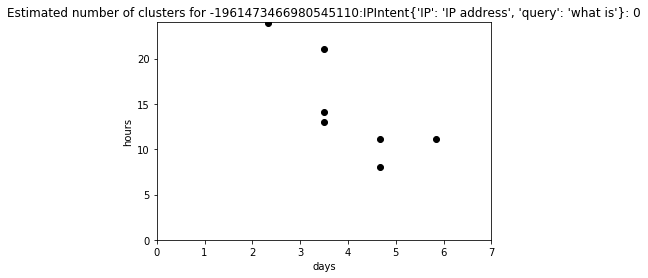

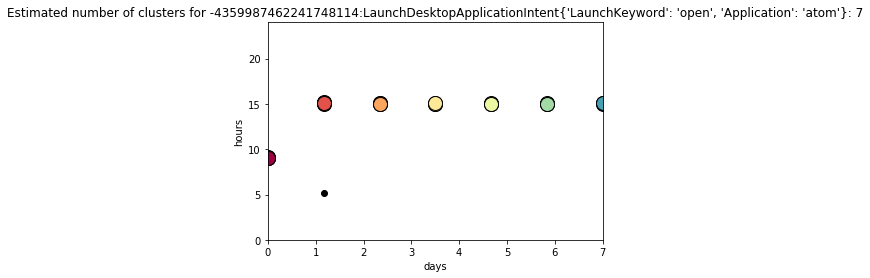

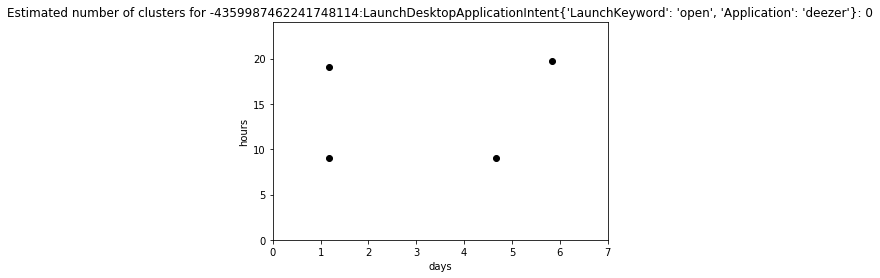

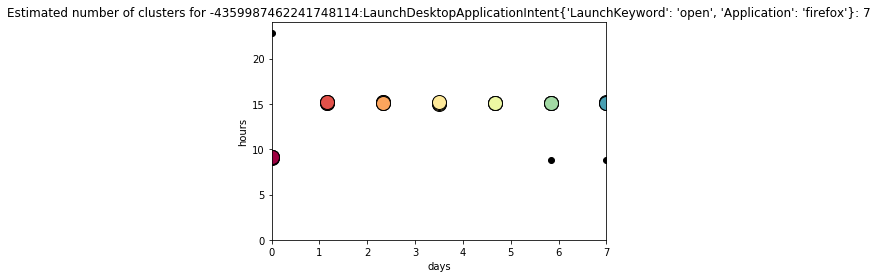

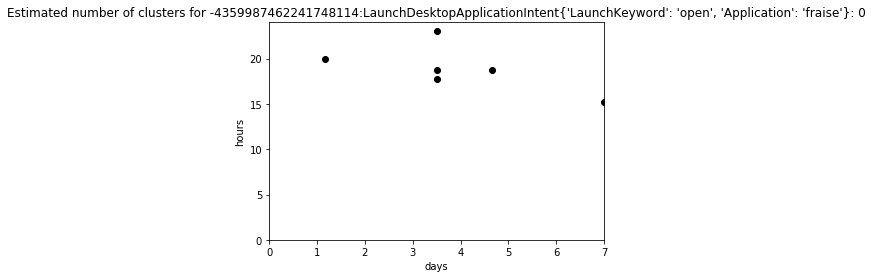

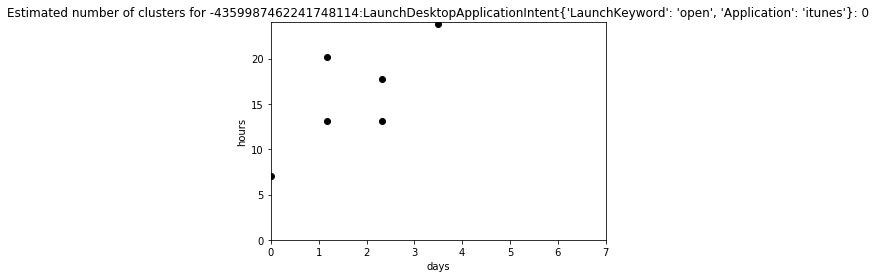

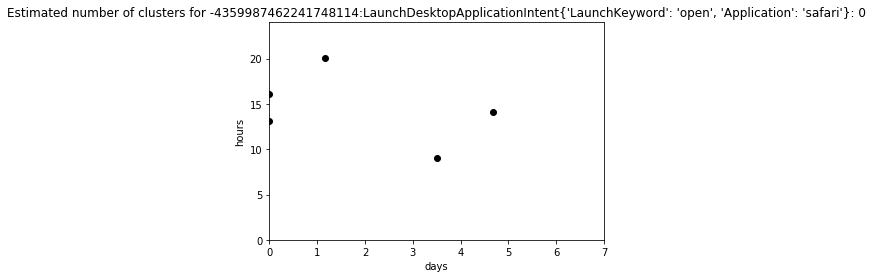

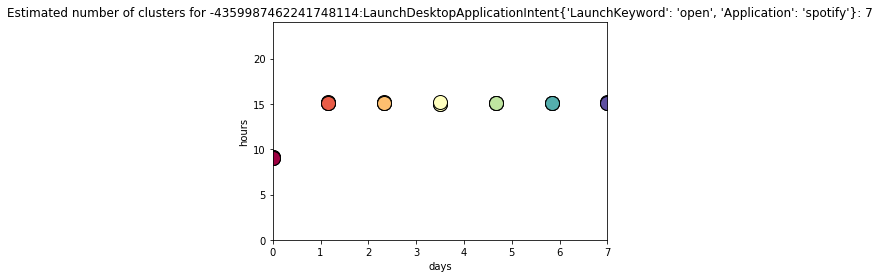

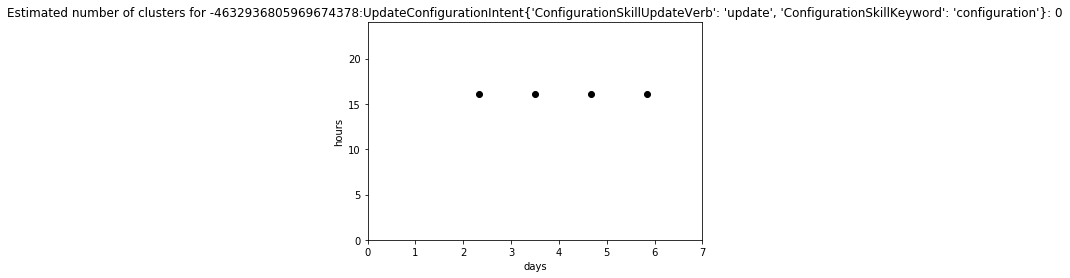

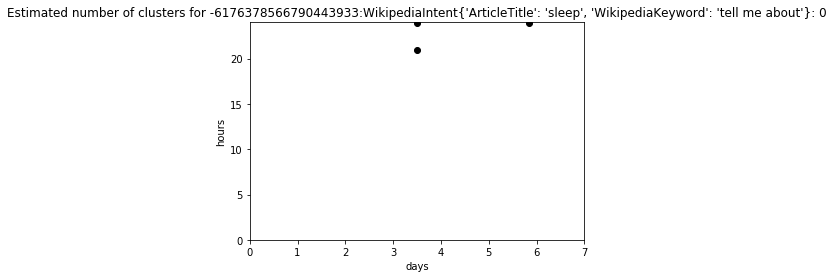

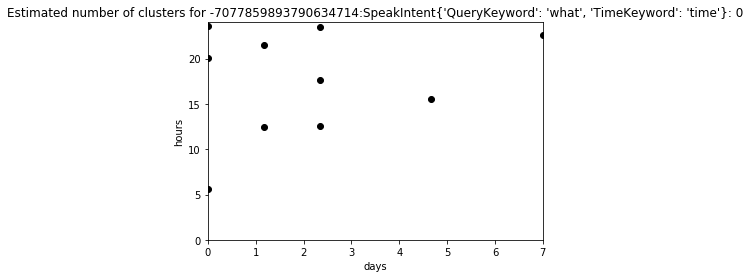

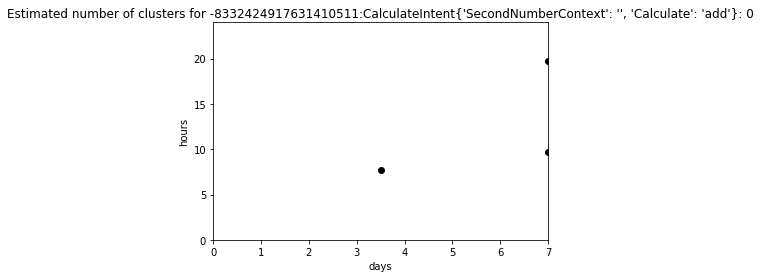

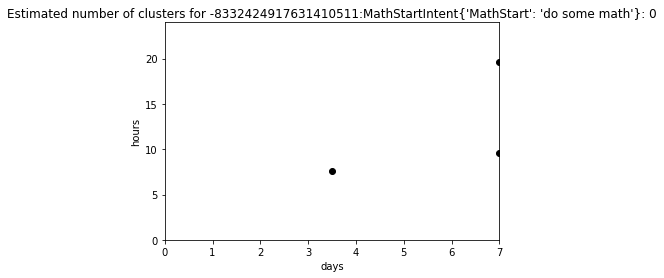

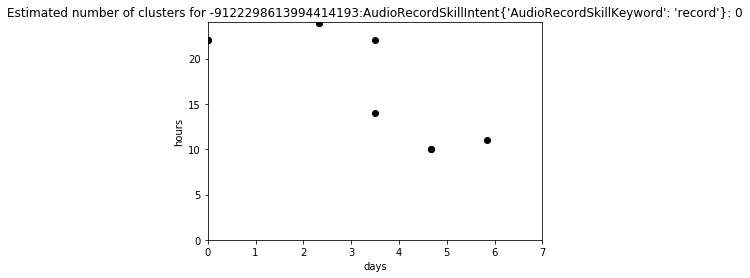

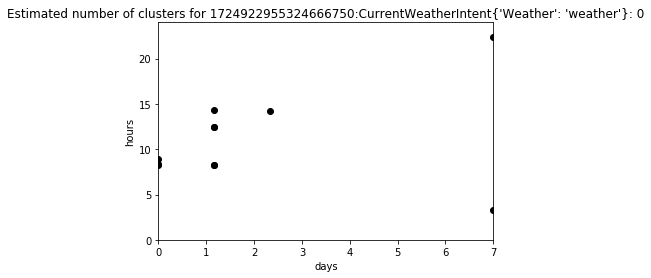

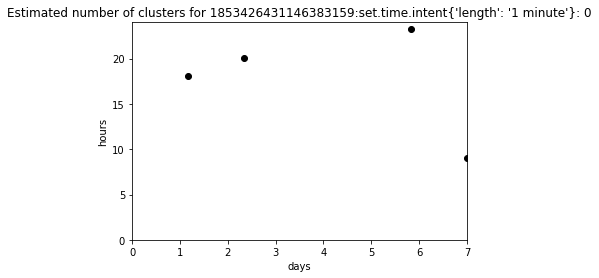

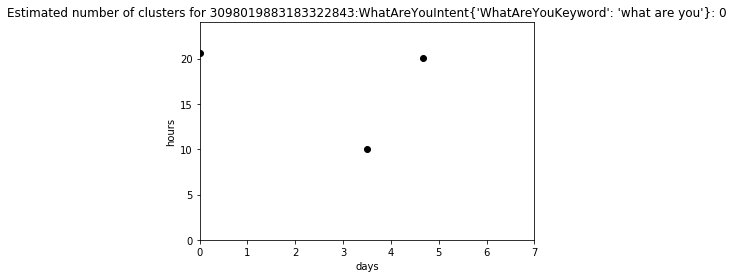

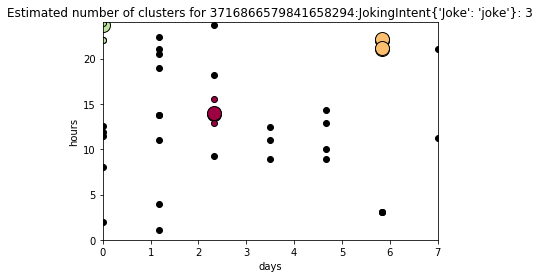

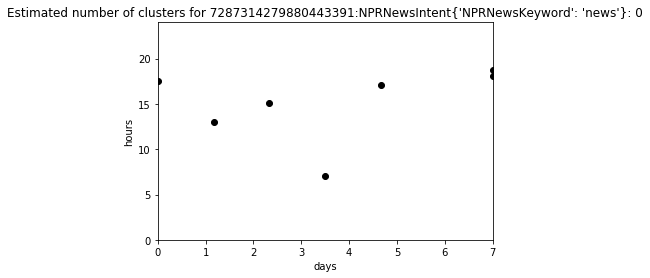

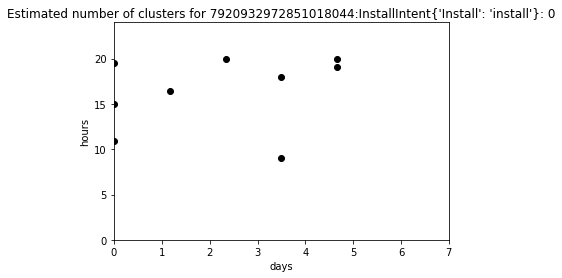

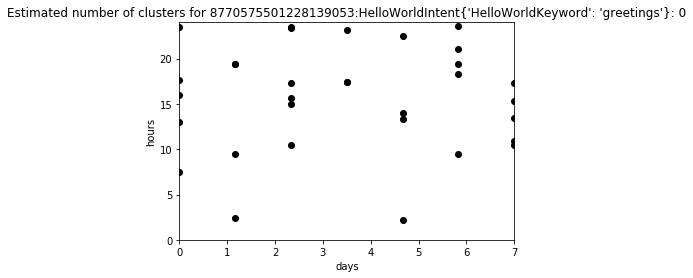

In [48]:
raw_data = read_json("/opt/mycroft/habits/logs.json")
X = parse_json(raw_data)
# Take hour and day for clustering
X_cluster = X[:, [0, 1]]
# compute dbscan per id
unique_ids = extract_ids(X[:,2])
for i in unique_ids:
    # even_numbers = list(filter(lambda x: x % 2 == 0, fibonacci))
    X_mini = X[X[:, 2] == i]
    if (X_mini[:, 0].shape[0] > 2):
        X_mini_cluster = X_mini[:, [0, 1]]
        # Affinity propagation
        # cluster_centers_indices, labels = compute_AP(X_mini_cluster)
        # dbscan
        core_samples_mask, labels = compute_DBSCAN(X_mini_cluster)

        # convert days and hours to 24 and 7 ranges

        def to_24(x): return (x / 10) * 7

        def to_7(x): return (x / 10) * 24

        X_mini[:, 0] = to_24(X_mini[:, 0].astype(float))
        X_mini[:, 1] = to_7(X_mini[:, 1].astype(float))
        X_mini_cluster[:, 0] = to_24(X_mini_cluster[:, 0].astype(float))
        X_mini_cluster[:, 1] = to_7(X_mini_cluster[:, 1].astype(float))

        # Plot AP
        # plot dbscan
        name = X_mini[0,2]
        plot_DBSCAN(X_mini_cluster,core_samples_mask,labels,name)